### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Library

In [2]:
!pip install tflite_support==0.1.0a0

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

import numpy as np
from PIL import Image
import cv2

### Preprocess Data

In [4]:
def load_data(filename, n_data_to_load):
    data = np.load(filename) #load data
    # print(filename + ': ' + str(len(data)))

    data = data[np.random.choice(len(data), size=n_data_to_load, replace=False)] #ambil n data secara random
    # print('sampled ' + filename + ': ' + str(len(data)))

    return data

In [5]:
def load_dataset(classes, n_data_to_load):
    data = []
    label = []
    i = 0
    for x in classes:
        filename = '/content/drive/MyDrive/dataset/dataset npy/'+x+'.npy'
        temp_data = load_data(filename, n_data_to_load)
        y = np.full(len(temp_data), i)
        i = i + 1
        data.append(temp_data)
        label.append(y)


    return np.array(data), np.array(label)


In [6]:
def map_reshape_concat(data):
    reshaped_image = np.reshape(data, ((data.shape[0] * data.shape[1]), data.shape[2]))
    return reshaped_image

In [7]:
def map_reshape(image):
    reshaped_image = np.reshape(image, (28, 28))
    return reshaped_image

In [8]:
def map_reshape_concat_label(label):
    reshaped_label = np.reshape(label, (label.shape[0] * label.shape[1]))
    return reshaped_label

In [9]:
def normalize_image(image):
    return image / 255.0

In [10]:
def expand_dim(data, index):
    return np.expand_dims(data, index)

In [11]:
def augment_data():
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=False,
  )
  return datagen

### Create Model

In [12]:
def model_resnet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(inputs)
    base_model = tf.keras.applications.resnet.ResNet50(
        input_shape=(56,56,3),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = True
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(43, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [13]:
def compile_model(model, loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc']):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [14]:
def train_model(model, train_data, train_label, validation_data, validation_label, epochs, batch_size=100, callbacks=None):
    return model.fit(
        train_data,
        train_label,
        validation_data=(validation_data, validation_label),
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=len(train_data) // batch_size,

    )

In [15]:
def train_model_withgenerator(dataAugmentaion, model, train_data, train_label, validation_data, validation_label, epochs, batch_size=100, callbacks=None):
  return model.fit_generator(
      dataAugmentaion.flow(train_data, train_label, batch_size = batch_size),
      validation_data = (validation_data, validation_label),
      steps_per_epoch = len(train_data) // batch_size,
      epochs = epochs,
      callbacks=callbacks
  )

### Initialization Label

In [16]:
classes = ['anjing', 'apel', 'awan', 'bebek', 'bintang', 'bus', 'bola basket',
           'buku', 'bunga', 'burung', 'daun', 'es krim', 'gunung', 'hujan', 'ikan', 'kaktus',
           'kalung', 'kaos', 'kelinci', 'koper', 'kue', 'kukis', 'kupu-kupu', 'lilin', 'lollipop',
           'lumba-lumba', 'mata', 'matahari', 'mobil', 'pantai', 'payung', 'pelangi', 'pesawat',
           'pisang', 'pohon', 'rumah', 'rumput', 'semangka', 'stroberi', 'sungai', 'topi', 'vas', 'wajah']
print('Total Class:', len(classes), 'class')

Total Class: 43 class


In [17]:
n_train = 5000
n_validation = 1000

In [18]:
data, label = load_dataset(classes, n_train)
# print(data.shape)
# print(label.shape)
data_validation, label_validation = load_dataset(classes, n_validation)

In [19]:
reshaped_flat_data = map_reshape_concat(data)
# print(reshaped_flat_data.shape)
# print(reshaped_flat_data[0])
reshaped_flat_data_validation = map_reshape_concat(data_validation)


In [20]:
reshaped_data = np.array([map_reshape(image) for image in reshaped_flat_data])
reshaped_data_validation = np.array([map_reshape(image) for image in reshaped_flat_data_validation])

In [21]:
reshaped_label = map_reshape_concat_label(label)
reshaped_label_validation = map_reshape_concat_label(label_validation)

In [22]:
normalized_reshaped_data = np.array([normalize_image(image) for image in reshaped_data])
normalized_reshaped_data_validation = np.array([normalize_image(image) for image in reshaped_data_validation])

In [23]:
input_data = expand_dim(normalized_reshaped_data, 3)
input_data_validation = expand_dim(normalized_reshaped_data_validation, 3)

In [24]:
input_data = np.repeat(normalized_reshaped_data[:, :, :, np.newaxis], 3, axis=3)
input_data_validation = np.repeat(normalized_reshaped_data_validation[:, :, :, np.newaxis], 3, axis=3)

In [25]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.Adam(lr=0.001)
metrics = ['acc']

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Training Augmentation

In [26]:
model_resnet = model_resnet((28,28,3))
print(model_resnet.summary())
compiled_model_resnet = compile_model(model_resnet, loss, optimizer, metrics)
data_aug = augment_data()

class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('acc') > 0.98):
      if (logs.get('val_acc') > 0.96):
        self.model.stop_training = True
callbacks = myCallbacks()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 56, 56, 3)         0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               104908

In [27]:
history = compiled_model_resnet.fit_generator(
      data_aug.flow(input_data, reshaped_label, batch_size=100),
      validation_data = (input_data_validation, reshaped_label_validation),
      steps_per_epoch = len(input_data) // 100,
      epochs = 25,
      callbacks=callbacks)

Epoch 1/25


<ipython-input-27-88ef3567ec76>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = compiled_model_resnet.fit_generator(


   6/2150 [..............................] - ETA: 3:34 - loss: 3.9613 - acc: 0.1183

2150/2150 [==============================] - 256s 113ms/step - loss: 0.9948 - acc: 0.7306 - val_loss: 1.1150 - val_acc: 0.6934
Epoch 2/25
2150/2150 [==============================] - 242s 112ms/step - loss: 0.6811 - acc: 0.8116 - val_loss: 0.9981 - val_acc: 0.7282
Epoch 3/25
2150/2150 [==============================] - 241s 112ms/step - loss: 0.6052 - acc: 0.8326 - val_loss: 0.8660 - val_acc: 0.7622
Epoch 4/25
2150/2150 [==============================] - 240s 112ms/step - loss: 0.5624 - acc: 0.8440 - val_loss: 0.7119 - val_acc: 0.8038
Epoch 5/25
2150/2150 [==============================] - 240s 112ms/step - loss: 0.5290 - acc: 0.8532 - val_loss: 0.5617 - val_acc: 0.8451
Epoch 6/25
2150/2150 [==============================] - 241s 112ms/step - loss: 0.4959 - acc: 0.8619 - val_loss: 0.6152 - val_acc: 0.8336
Epoch 7/25
2150/2150 [==============================] - 240s 112ms/step - loss: 0.4773 - acc: 0.8667 - val_loss: 0.7129 - val_acc: 0.7991
Epoch 8/25
2150/2150 [=======================

### Visualization Loss and Accuracy

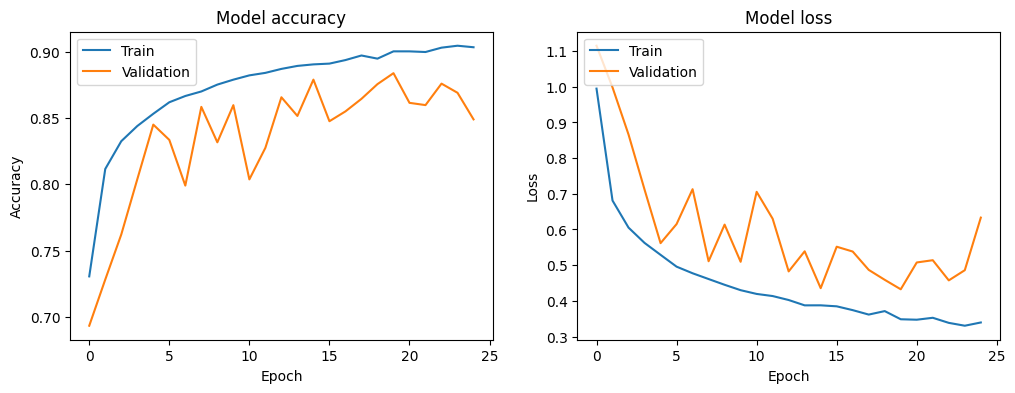

In [28]:
# Visualisasi Loss dan Akurasi
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history)


### Save Model

In [29]:
# model_resnet.save("model_resnet.h5")
compiled_model_resnet.save("model_resnet_baru.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
import tensorflow as tf

# Load the saved model
saved_model_path = "model_resnet_baru.h5"
model = tf.keras.models.load_model(saved_model_path)

# Convert the model to TensorFlow Lite format with select TensorFlow ops
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable select TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("model_resnet_3channel.tflite", "wb") as f:
    f.write(tflite_model)


### Create Metadata

In [31]:
# Load the TensorFlow Lite model
model_path = 'model_resnet_3channel.tflite'
with open(model_path, 'rb') as f:
    model_buffer = f.read()

# Create the metadata for the model
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "One Channel ResNet50 Image Classifier"
model_meta.description = "Identify the most prominent object in the image"
model_meta.version = "v1"
model_meta.author = "fasimagiland"
model_meta.license = "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0."

# Create input info
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "input"
input_meta.description = "Input image to be classified"
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = _metadata_fb.ColorSpaceType.RGB
input_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.ImageProperties
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = _metadata_fb.ProcessUnitOptions.NormalizationOptions
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [0.0]
input_normalization.options.std = [255.0]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Create output info
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "output"
output_meta.description = "Probabilities of the 43 labels respectively"
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.FeatureProperties
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats

label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels_fasimglnd.txt")
label_file.description = "Labels for objects that the model can recognize"
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

# Create subgraph info
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

# Create a flatbuffer builder
b = flatbuffers.Builder(0)
b.Finish(model_meta.Pack(b), _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

# Create a metadata populator
populator = _metadata.MetadataPopulator.with_model_file(model_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels_fasimglnd.txt"])
populator.populate()

model_with_metadata_path = 'model_baruMetadata.tflite'
with open(model_with_metadata_path, 'wb') as f:
    f.write(populator.get_model_buffer())

### Predict New Data

hujan - 0.9987
rumput - 0.0013
payung - 0.0000
pantai - 0.0000
kalung - 0.0000


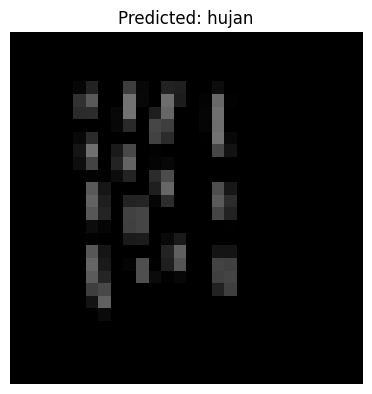

In [32]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Buka gambar dan konversi ke grayscale
    image = image.resize((28, 28))  # Ubah ukuran gambar menjadi 28x28
    image_array = np.array(image)  # Konversi gambar ke numpy array
    normalized_image = normalize_image(image_array)  # Normalisasi gambar ke rentang [0, 1]
    reshaped_image = map_reshape(normalized_image)  # Menggunakan fungsi map_reshape
    input_image = expand_dim(normalized_image, -1)  # Tambahkan dimensi channel (28, 28, 1)
    input_image = np.repeat(input_image, 3, axis=-1)  # Ulangi channel untuk membuatnya 3 channel (28, 28, 3)
    input_image = expand_dim(input_image, 0)  # Tambahkan dimensi batch (1, 28, 28, 3)
    input_image = input_image.astype(np.float32)  # Konversi ke float32
    return input_image

# Fungsi untuk memuat model TFLite
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

# Fungsi untuk melakukan prediksi dengan model TFLite
def predict(interpreter, image):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])

    return predictions

# Memuat dan memproses gambar baru
image_path = 'hujan.jpg'  # Ganti dengan path gambar Anda
input_image = preprocess_image(image_path)

# Memuat model TFLite
tflite_model_path = 'model_baruMetadata.tflite'
interpreter = load_tflite_model(tflite_model_path)

# Melakukan prediksi
predictions = predict(interpreter, input_image)
predicted_class_index = np.argmax(predictions)
predicted_class_name = classes[predicted_class_index]

# Mendapatkan 5 probabilitas kelas tertinggi
top_5_indices = np.argsort(predictions[0])[::-1][:5]
top_5_classes = [classes[i] for i in top_5_indices]
top_5_probabilities = predictions[0][top_5_indices]

# Menampilkan hasil
for class_name, probability in zip(top_5_classes, top_5_probabilities):
    print(f"{class_name} - {probability:.4f}")

# Visualisasi gambar dan probabilitas
plt.figure(figsize=(10, 5))

# Menampilkan gambar
plt.subplot(1, 2, 1)
plt.imshow(input_image[0], cmap='gray')
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')

plt.show()